# RespiCoV sequencing analysis

Reads fastq file(s) from nanopore sequencing output using [RespiCoV](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0264855) primers

TODO
 * Create histogram of distance between hits - primer-dimer analysis
 * Factor out primer pair prediction
 * Create histogram of primer pair spans
 * Compare typical spans by primer base name
 * Break out pair analysis by subdir
 * Generally get pair analysis to highlight the real matches

## Initialization and configuration

In [1]:
from Bio.Seq import Seq
from Bio import SeqIO
import os
import gzip
import pandas as pd

fastQBaseDir = "../20221204_2344_MN41817_FAV39017_1bf37150/fastq_pass/"

pd.options.display.max_rows = 100
pd.options.display.min_rows = 50

primers = list(SeqIO.parse("RespiCovPrimers.fasta", "fasta"))
print("Read %i primers" % (len(primers)))

# Store primer indicies for efficient serialization
# Also precompute reverse complements for a ~5% speedup over using 'strand'
for i, primer in enumerate(primers):
        primer.index = i
        primer.rcSeq = primer.seq.reverse_complement()

Read 113 primers


## Compute and save primer matches if needed
Includes all the functions for getting reads and hits

In [39]:
from IPython.display import clear_output 
from Bio import Align
from dataclasses import dataclass
import time
import json

# Look for at least an 80% match against primers
# Below about 70% we seem to get huge numbers of matches just by chance
MATCH_THRESHOLD = 0.80

# Hits which overlap atleast 80% of a higher-score hit aren't reported
OVERLAP_THRESHOLD = 0.80

@dataclass
class Hit():
    primer: Seq
    start: int     # read index, 0-based
    end: int       # read index past the end of the alignment
    rev: bool
    mr: float

primer_hits_to_print = 0

aligner = Align.PairwiseAligner(mode='local', match_score=1, mismatch_score=0, gap_score=-1)

# Get the amount of overlap between two hits. 1.0 means perfect overlap, 0.0 means not overlapping.
def computeOverlap(hit1, hit2):
    # The overlap fraction is the distance between the leftmost end the rightmost start
    # divided by the length of the smaller primer. This will be 1.0 for a 
    o = (min(hit1.end,hit2.end)-max(hit1.start,hit2.start)) / \
        min(len(hit1.primer),len(hit2.primer))
    return o if o > 0 else 0

# Given a sequencing read, compute and return a list of primer match hits
def computePrimerHits(read):
    hits = []
    global primer_hits_to_print
    for primer in primers:
        for query in (primer.seq, primer.rcSeq):
            # Find the single best alignment
            # Scoring seems to be ~10x faster than finding alignments
            score = aligner.score(read.seq, query)
            mr = round(score / len(query), ndigits=2)
            if mr >= MATCH_THRESHOLD:
                alignment = aligner.align(read.seq, query)[0]
                assert alignment.score == score
                # TODO consider looking for the same primer elsewhere by masking the match?
                if primer_hits_to_print > 0:
                    print("Match: %.2f %s%s" % (mr, primer.description, "" if query==primer.seq else " (rev)"))
                    print(alignment)
                    primer_hits_to_print -= 1
                hit = Hit(
                    primer=primer, 
                    start=int(alignment.coordinates[0][0]), 
                    end=int(alignment.coordinates[0][-1]),
                    rev=query != primer.seq,
                    mr=mr)
                assert hit.start < len(read.seq) and hit.end <= len(read.seq), \
                    "Start %d, End %d, Len %d\n%s" % \
                    (alignment.start, alignment.end, len(read.seq), alignment)
                hits.append(hit)
    # Remove redundant hits that are lower scoring
    hits.sort(key=lambda h: h.mr, reverse=True)
    trimmedHits = []
    for i in range(len(hits)):
        redundant = False
        for j in range(i):
            o = computeOverlap(hits[i],hits[j])
            if o >= OVERLAP_THRESHOLD:
                redundant = True
                break
        if not redundant:
            trimmedHits.append(hits[i])
    return trimmedHits

def serializeHit(hit):
    return [hit.primer.index, hit.start, hit.end, hit.rev, hit.mr]

def deserializeHit(hitBuf):
    return Hit(primer=primers[hitBuf[0]], start=hitBuf[1], end=hitBuf[2], rev=hitBuf[3], mr=hitBuf[4])

def getFastQAndHitsFiles(subdir):
    fastQDir = os.path.join(fastQBaseDir, subdir)
    for file in sorted(filter(lambda f: f.endswith(".fastq.gz"), os.listdir(fastQDir))):
        fastQPath = os.path.join(fastQDir, file)
        yield (fastQPath, fastQPath.removesuffix(".fastq.gz")+"-hits.json")

# Get reads from a gzipped fastQ file
def readFastQ(path):
    with gzip.open(path, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            yield record

# Find primer matches and save them to files if files don't already exist
def generateHitsFile(subdir, overwrite=False):
    for (fastQPath, hitsPath) in getFastQAndHitsFiles(subdir):
        if overwrite or not os.path.exists(hitsPath):
            print("Processing ", os.path.basename(fastQPath), end="")
            reads = 0
            start = time.process_time()
            serializedHitsPerRead = []
            for read in readFastQ(fastQPath):
                reads += 1
                if reads % 100 == 0:
                    print(".",end="")
                hits = computePrimerHits(read)
                serializedHitsPerRead.append([serializeHit(hit) for hit in hits])

            elapsed = time.process_time() - start
            print("  %.2fs" % elapsed)

            with open(hitsPath, "w") as f:
                json.dump(serializedHitsPerRead, f)
        else:
            print("Found ", os.path.basename(hitsPath))

def getAllFastQDirs():
    for dir in sorted(os.listdir(fastQBaseDir)):
        if dir.startswith("barcode"):
            yield dir

# Return all raw reads in a sub-directory on their own
def getReads(subdir):
    for (fastQPath,_) in getFastQAndHitsFiles(subdir):
        for read in readFastQ(fastQPath):
            yield read

def getAllReads():
    for subdir in getAllFastQDirs():
        for read in getReads(subdir):
            yield read

# Stream all reads for a given subdirectory, along with the pre-computed primer matches
def getPrimerMatches(subdir):
    for (fastQPath,hitsPath) in getFastQAndHitsFiles(subdir):
        with open(hitsPath, "r") as hitsFile:
            serializedHitsPerRead = json.load(hitsFile)
            
        for (readIdx,read) in enumerate(readFastQ(fastQPath)):
            hits = []
            for hitBuf in serializedHitsPerRead[readIdx]:
                hit = deserializeHit(hitBuf)
                assert hit.start < len(read.seq)
                assert hit.end <= len(read.seq)
                hits.append(hit)
            yield (read, hits)
                
def getAllPrimerMatches():
    for subdir in getAllFastQDirs():
        for (r,h) in getPrimerMatches(subdir):
            yield (subdir, r, h)

# Actually generate all the hits files
for subdir in getAllFastQDirs():
    generateHitsFile(subdir)

Found  FAV39017_pass_barcode01_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode02_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode03_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode04_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode05_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode06_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode07_1d0a44b7_0-hits.json
Found  FAV39017_pass_barcode08_1d0a44b7_0-hits.json


## How many primers are found in each read?
Notable here is that, in my first experiment nearly every read included at least one primer, suggesting PCR products did dominate the results. 
Proper amplification and sequencing should typically result in 2 primers per read, which is indeed the most common result. But it's also very common to have only a single primer.
It's also not unusual to have several primers, suggesting primer-dimers.

In [45]:
from collections import Counter

readsPerPrimerCount = Counter()
readTotal = 0
for (subdir, read, hits) in getAllPrimerMatches():
    readTotal += 1
    readsPerPrimerCount[len(hits)] += 1

table = pd.DataFrame.from_dict(readsPerPrimerCount, orient="index", columns=["Reads"])
table.index.name = "Primer Count"
table.sort_index(inplace=True)
table["%"] = table["Reads"].apply(lambda r: round(r / readTotal * 100, ndigits=2))
table

b9052c5f-4355-4895-97c8-5297c57cc1c7
16f30f32-1258-4fa6-85cf-7465cd94167b
16699b17-ab2b-49c9-87cd-150e0b1eb61d
9824ef5c-449a-4cae-9abe-5a002bd1b33c
1aad320a-2522-4b1a-83ce-9847d2df2ac5
2a4cdc72-c989-4b8d-9f11-0d904aded7b5
e66c538f-0fb9-4ad2-b04d-8adf7a3faed7
7b073fe6-dd45-4ae1-8bcd-6a00121b899e
d003729c-cb20-4517-8a4d-34e31c4310cf


,Reads,%
Primer Count,,
0,214,3.85
1,1297,23.35
2,3245,58.42
3,488,8.78
4,252,4.54
5,32,0.58
6,18,0.32
7,9,0.16


## What is the distribution of primer match scores
Most hits exactly match a primer, but small numbers of mismatches are not uncommon.
In earlier testing, match scores of around 60% and lower were extremely common, purely by chance.

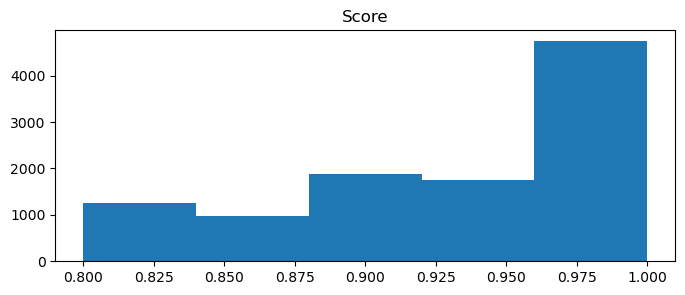

In [4]:
from collections import Counter

mrs = []
for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        mrs.append(hit.mr)

pd.DataFrame({'Score': mrs}).hist(figsize=(8,3), bins=5, grid=False);

## How often is each primer seen?
With a highly-specific PCR reaction I would expect to see the primer matches dominated by the legitimate target sequences. That's not the case here, suggesting perhaps the annealing temp was too low. More analysis is clearly needed in order to identify likely targets in the data.

In [5]:
hitsPerPrimer = dict()
for p in primers:
    hitsPerPrimer[p.description] = [0,0,0]

hitsTotal = 0
for (subdir, record, hits) in getAllPrimerMatches():
    hitsTotal += len(hits)
    for hit in hits:
        hitsPerPrimer[hit.primer.description][1 if hit.rev else 0] += 1
        hitsPerPrimer[hit.primer.description][2] += hit.mr

def addPercent (entry):
    (primer, [fwd,rev,mrtot]) = entry
    return (primer, fwd, rev, round((fwd+rev) / hitsTotal * 100, ndigits=2), round(mrtot / (fwd+rev), ndigits=2))

data = map(addPercent, filter(lambda p:p[1]!=[0,0,0], hitsPerPrimer.items()))
table = pd.DataFrame(data, columns=["Primer","Fwd hits", "Rev hits", "%", "Avg MR"])
table.set_index("Primer", inplace=True)
table.sort_values("%", ascending=False, inplace=True)
table

,Fwd hits,Rev hits,%,Avg MR
Primer,,,,
Influenza A virus 2,125,131,2.42,0.96
Chlamydophila pneumoniae 2,128,117,2.31,0.95
SARS coronavirus 1/2 3,130,115,2.31,0.94
Mycoplasma pneumoniae 1,139,101,2.27,0.95
Hendra virus 5,131,108,2.26,0.94
Hantaan virus 3,95,134,2.16,0.95
Streptococcus pneumoniae 2,110,104,2.02,0.95
Human parechovirus 1,86,109,1.84,0.96
Mycoplasma pneumoniae 2,98,94,1.81,0.92


## Which primers are never seen exactly?
If a primer is never seen at all, that may suggest a failure in the assay preparation
or synthesis. 

In [6]:
primerMaxMatch = dict.fromkeys(map(lambda p:p.description, primers), 0.0)

for (subdir, record, hits) in getAllPrimerMatches():
    for hit in hits:
        if primerMaxMatch[hit.primer.description] < hit.mr:
            primerMaxMatch[hit.primer.description] = hit.mr

table = pd.DataFrame.from_dict(primerMaxMatch, orient="index", columns=["Max Match"])
table.index.name = "Primer"
table.sort_values("Max Match", ascending=False, inplace=True)
table[table["Max Match"] < 1.0]

,Max Match
Primer,
Influenza A virus 22,0.96
Influenza A virus 20,0.96
Influenza B virus 5,0.87
Human respiratory syncytial virus 1,0.00


## What's the distribution of read lengths and primer positions?
The relative position of primer hits in the reads creates an unsual bimodal pattern. I'm not sure what to make of this.

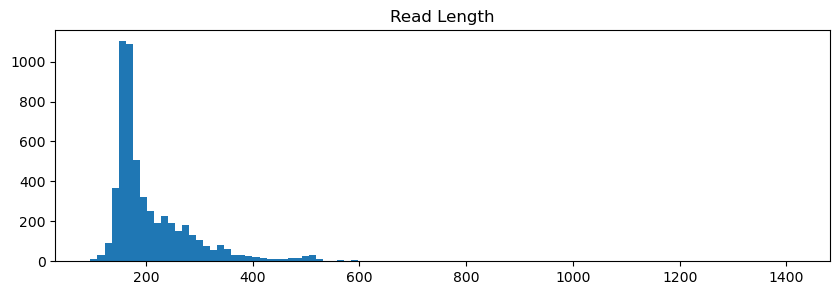

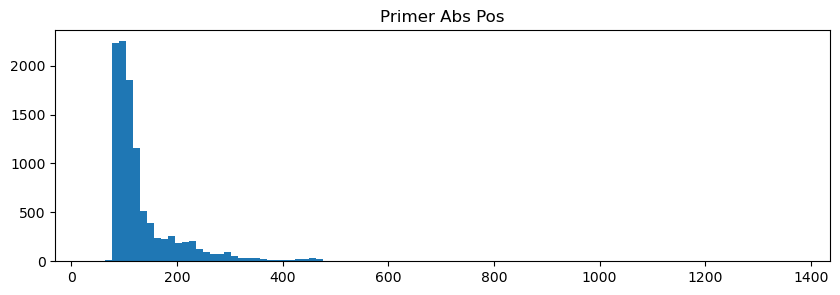

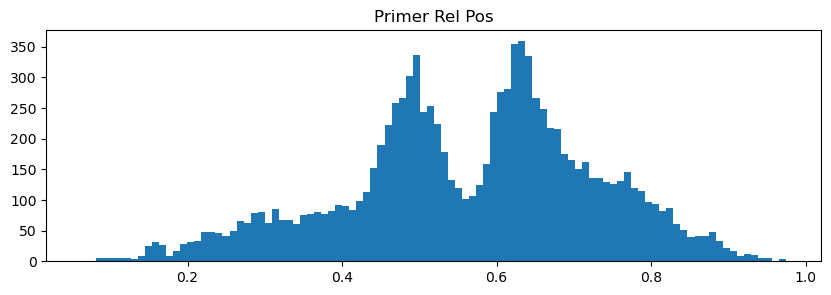

In [14]:
lengths=[]
paPos=[]
prPos=[]

for (subdir, read, hits) in getAllPrimerMatches():
    lengths.append(len(read.seq))
    paPos += map(lambda hit: hit.end, hits)
    prPos += map(lambda hit: (hit.start+hit.end)/2/len(read.seq), hits)

pd.DataFrame({'Read Length': lengths}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Abs Pos': paPos}).hist(bins=100, figsize=(10,3), grid=False)
pd.DataFrame({'Primer Rel Pos': prPos}).hist(bins=100, figsize=(10,3), grid=False);

## How much do primers overlap below our threshold?

Max overlap score: 0.78, read 35e315b6-3dc9-4f51-9974-0be98e9e45d5
Influenza B virus 5 mr=0.80
target           81 AAATTATTCAAGGCATGTAAAATGAAGAA 110
                  0 |||||||||||.|||.||||||..|.|||  29
query             0 AAATTATTCAATGCAAGTAAAACTAGGAA  29

Human coronavirus NL63 1 mr=0.96
target           92 GGCATGTAAAATGAAGAAGGAGG 115
                  0 ||||||||||||||||.||||||  23
query             0 GGCATGTAAAATGAAGGAGGAGG  23



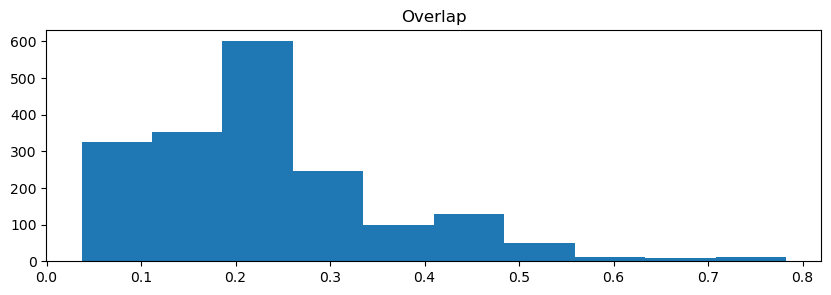

In [42]:
# Find the hits with the maximum overlap (below our threshold)
overlaps = []
maxo = 0
maxhit = None
for (subdir, read, hits) in getAllPrimerMatches():
    for i in range(len(hits)):
        for j in range(i):
            o = computeOverlap(hits[i],hits[j])
            if o > 0:
                overlaps.append(o)
                if o > maxo:
                    maxo = o
                    maxhit = (read, hits[i], hits[j])

print("Max overlap score: %.2f, read %s" % (maxo, maxhit[0].id))
print("%s mr=%.2f" % (maxhit[1].primer.description,maxhit[1].mr))
print(aligner.align(maxhit[0].seq, maxhit[2].primer.rcSeq if maxhit[1].rev else maxhit[1].primer.seq)[0])
print("%s mr=%.2f" % (maxhit[2].primer.description,maxhit[2].mr))
print(aligner.align(maxhit[0].seq, maxhit[2].primer.rcSeq if maxhit[2].rev else maxhit[2].primer.seq)[0])
      
pd.DataFrame({'Overlap': overlaps}).hist(figsize=(10,3), grid=False);


## Find possible primer pairs

In [43]:
showSequence = True
for (subdir, record, hits) in getAllPrimerMatches():
    for hit1 in hits:
        if not hit1.rev:
            desc = hit1.primer.description[:hit1.primer.description.rindex(' ')]
            for hit2 in hits:
                if hit2.rev and hit2.primer.description.startswith(desc):
                    span = hit2.start - hit1.end - 1 if hit2.start > hit1.start else hit1.start - hit2.end - 1
                    if span > 150:
                        print("%s %s: %d %s @(%d,%d) %.2f - %s @(%d,%d) %.2f" % \
                              (subdir, record.id, span, hit1.primer.description, hit1.start, hit1.end, hit1.mr, \
                               hit2.primer.description, hit2.start, hit2.end, hit2.mr))
                        if showSequence:
                            (s,e) = (hit1.start, hit2.end) if hit2.start > hit1.start else (hit2.start, hit1.end)
                            print(record.seq[s:e])
                            print()

barcode01 c8858df3-aed7-4268-b1ec-195b9e8daa93: 159 Influenza A virus 7 @(68,89) 1.00 - Influenza A virus 2 @(249,268) 1.00
GCCATCATGACAAGCACTTGCAGGTCAAACATTGCACATAGGTGACAAAGAAAAGATTTTTTTCTTTTTTTTTTGAGATGGAGTCTCGCTCTGTTGCCTAGGCTGGGTGCAATGGTGCAATCTCAGCTCACTGCAACCTCTGCCTCCTGGATTCAAGTGATTCTCTGGCCTCAGCTACAGGCAGCTGGCAAGTGCACCAG

barcode01 f1d19733-f32a-4aea-a452-19bafdcfb71e: 255 Influenza A virus 8 @(69,95) 1.00 - Influenza A virus 2 @(351,369) 0.95
TATTGAGAACACAAGAGTCTGAATGTTAATCCCCAAGACAATGAAGACATGTCTCAGGGCATGTCAGAGGCCTTCACGGCAGCTCCTCCCATCACAGGCCCAGAAGGCCTAGGAGAAATGATTTTGTGGGCCGGGCTCAGGGTCCCTGTGCTGCTATGCAGCCCTAGGGACTTGGTACCCTTGTCCCAGCCACTCCAGCTGTAGCTGCCGAGGGCTAATGTAGGCTTGGACCGTATTTTGGGGTTGAAGCCCCAAACCTTGGCAGCTTCCATGGCAGTGTTGAGCTGGCAAGTGCACCAG

barcode01 a717dfe9-d027-4eb6-a9d1-560eaeb7a71c: 181 Human adenovirus 8 @(67,83) 0.88 - Human adenovirus 13 @(265,281) 0.82
GCAGTGCGGAGTAGGGAAAGGGAAAGCAGAGCGTGGGACTGTCCCTCTGTGCTGGAAGAGGGCTAACACAGCCCCGACTCTCCGCTCTGGCTGAGCCGAGGGGCCTCTCGCCTCCCTCTGTGTTG

# Debugging

In [48]:
# Dump all the matches for specific known reads for debugging purposes
primer_hits_to_print = 50
for read in getAllReads():
    interestingReads = [
        "c63d9144-0d93-4620-ba79-2a7bf050e813",  # rhinovirus match
        "6129522a-5587-4009-ad7d-e76d677283ab",  # rhinovirus reverse match
        "35e315b6-3dc9-4f51-9974-0be98e9e45d5",  # max overlap
        "b9052c5f-4355-4895-97c8-5297c57cc1c7",  # 7 hits
        "825687be-49e0-4c4b-a950-609181d23d78",  # longest read (1400bp) but with only one hit
    ]
    if read.id in interestingReads:
        print("Read %s len %i" % (read.id,len(read.seq)))
        hits = computePrimerHits(read)
        if len(hits)>0:
            print("Match summary:")
            for hit in hits:
                print("   %.2f %i-%i: %s (%d%s)" % (hit.mr, hit.start, hit.end, hit.primer.description, len(hit.primer), " rev" if hit.rev else ""))
                print("    " + read.seq[hit.start:hit.end])
                print("    " + read.seq[hit.start:hit.end].reverse_complement())
            print("")

Read b9052c5f-4355-4895-97c8-5297c57cc1c7 len 288
Match: 0.80 Hendra virus 5 (rev)
target          173 AGCTGCAAAATTTGGCTT 191
                  0 |||||||||-||||||||  18
query             3 AGCTGCAAA-TTTGGCTT  20

Match: 0.86 Human adenovirus 6
target           92 TTGTAAGCAGTGCCAGAGT 111
                  0 |||||||||||||||||||  19
query             0 TTGTAAGCAGTGCCAGAGT  19

Match: 0.96 Human coronavirus 229E 2 (rev)
target          208 GCGGCTCTTAAATCTTTAGGTTTT 232
                  0 ||||||||||||||||||||||||  24
query             0 GCGGCTCTTAAATCTTTAGGTTTT  24

Match: 0.95 Influenza A virus 1
target          124 CTGGTGCACTTGCCAGCTG 143
                  0 ||||||||||||||||.||  19
query             0 CTGGTGCACTTGCCAGTTG  19

Match: 1.00 Influenza A virus 2
target          124 CTGGTGCACTTGCCAGCTG 143
                  0 |||||||||||||||||||  19
query             0 CTGGTGCACTTGCCAGCTG  19

Match: 1.00 Nipah virus 2 (rev)
target          104 CCAGAGTGACCTCAACACCA 124
                  0 |||||